In [90]:
# Vamos a aplicar Grover para encontrar las trazas posibles en una detección de 4 capas. Consideramos cada capa del detector como
# |0|1|2|3|4|5|6|7| de tal manera que un hit en la capa i es, por ejemplo, 5.
# Dada una combinacion de hits (h1,h2,h3,h4) candidatos a ser traza, comprobamos que 
# m1=h1+h4 = h2+h3=m2 (no es estrictamente correcto pero para ir viendo)
# La representación en binario de estas dos sumas es m1=(x1x2x3x4), m2=(y1y2y3y4), y estos dígitos son los que introducimos como qubits

import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

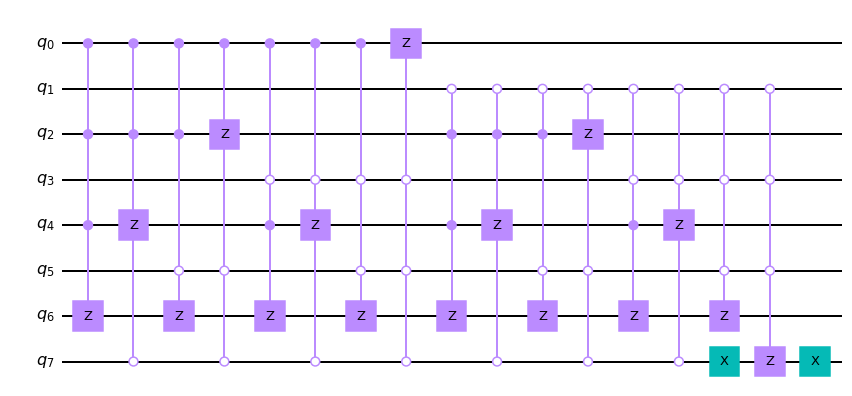

In [91]:
# Lo que hace este oracle es comprobar cuales son los las combinaciones (x1x2x3x4),(y1y2y3y4) solución, es decir, ambas son ceros o unos en las mismas posiciones
# Pues si los hits forman una linea recta se tendrá m1=m2 (again, no del todo correcto)
# El oracle se aplica a un estado inicial que represente todas las combinaciones posibles de las trazas. Esto lo hacemos luego con state_preparation
# & : and, | : or, ^ : xor

# oracle = PhaseOracle('((x1&y1)|(~x1&~y1))&((x2&y2)|(~x2&~y2))&((x3&y3)|(~x3&~y3))&((x4&y4)|(~x4&~y4))')
# oracle.draw(output='mpl')

c example DIMACS-CNF 3-SAT
p cnf 8 8
-5 1 0
-1 5 0
-6 2 0
-2 6 0
-7 3 0
-3 7 0
-8 4 0
-4 8 0



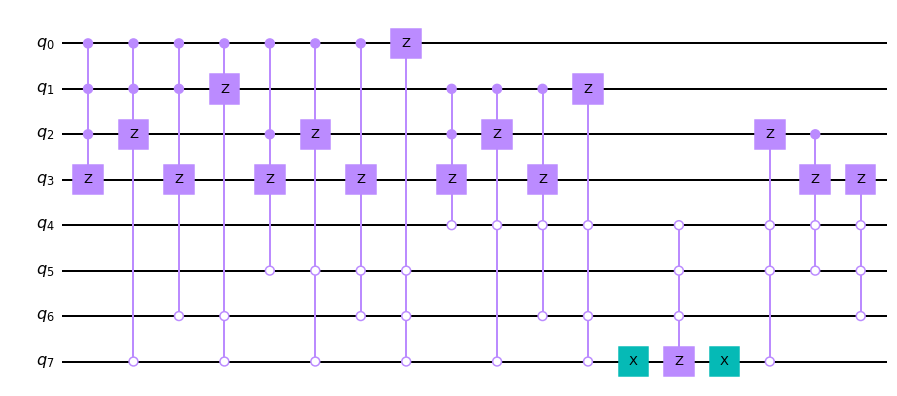

In [124]:
with open('tracking2.dimacs', 'r') as f:
    dimacs = f.read()
print(dimacs)

oracle = PhaseOracle.from_dimacs_file('tracking2.dimacs')
oracle.draw(output='mpl')

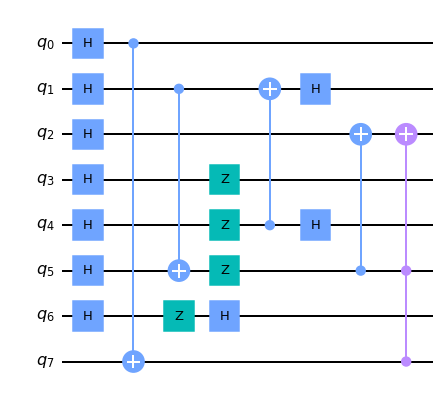

In [144]:
# Preparamos los estados que nos interesan segun las medidas del detector
# (Esto es complicado)
# Suponemos que ya hemos hecho una criba inicial en la que eliminamos combinaciones de hits absurdas, solo dejando lineas rectas.

# Por ejemplo, podemos tener las candidatas a trazas (1111),(1357),(1334),(1134),(1311),(1354),(1331)

state_preparation = QuantumCircuit(8)
state_preparation.h([0,1,2,3,4,5,6])
state_preparation.cx(0,7)
state_preparation.cx(1,5)
state_preparation.z([3,4,5,6])
state_preparation.cx(4,1)
state_preparation.h([1,4,6])
state_preparation.cx(5,2)
state_preparation.ccx(7,5,2)
#state_preparation.measure([0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7]) # descomentar para aplicar el histograma siguiente y ver qué estados prepara
state_preparation.draw(output='mpl')

# (Este circuito no prepara a esos candidatos, no consigo establecer la superposición buscada. Aún así, con este ejemplo se puede ver que funciona bien)


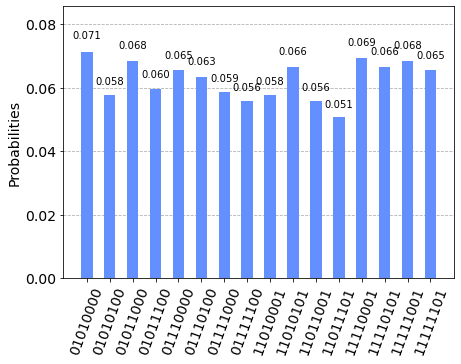

In [65]:
# # Aquí deberíamos obtener los vectores (x1x2x3x4y1y2y3y4) propios de nuestras medidas para que tenga sentido lo que estamos haciendo.
# # Asimismo, deberiamos obtener las mismas amplitudes, aproximadamente.

# aer_sim = Aer.get_backend('aer_simulator')
# shots = 1024
# qobj = assemble(state_preparation, aer_sim)
# results = aer_sim.run(qobj).result()

# plot_histogram(results.get_counts())

In [94]:
# Para poder trabajar con este Verifier he metido la expresión lógica de arriba en un archivo dimacs: tracking2.dimacs
# Previamente he tenido que pasar esa expresión a CNF

class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess]
        
        count=0
        
        
        for line in self.dimacs.split('\n'):
            count=count+1
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):

                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
             
               
                
               
            if clause_eval is False:
                return False
            if count == 10:
                return True
        return True  
            
        

In [132]:
# Vemos si funciona bien o no
v=Verifier('tracking2.dimacs')
v.is_correct('11101110')

True

In [145]:
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=3000)



# Con AmplificationProblem podemos decir a grover por donde debe mirar, en este caso por state_preparation

problem = AmplificationProblem(oracle = oracle, state_preparation=state_preparation, is_good_state=v.is_correct)



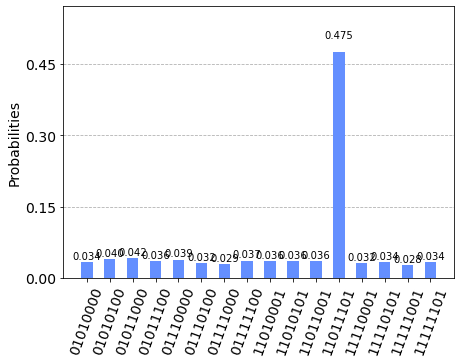

In [141]:

# Usamos grover con los atributos que necesitamos y representamos los resultados.
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
plot_histogram(result.circuit_results[0])
   

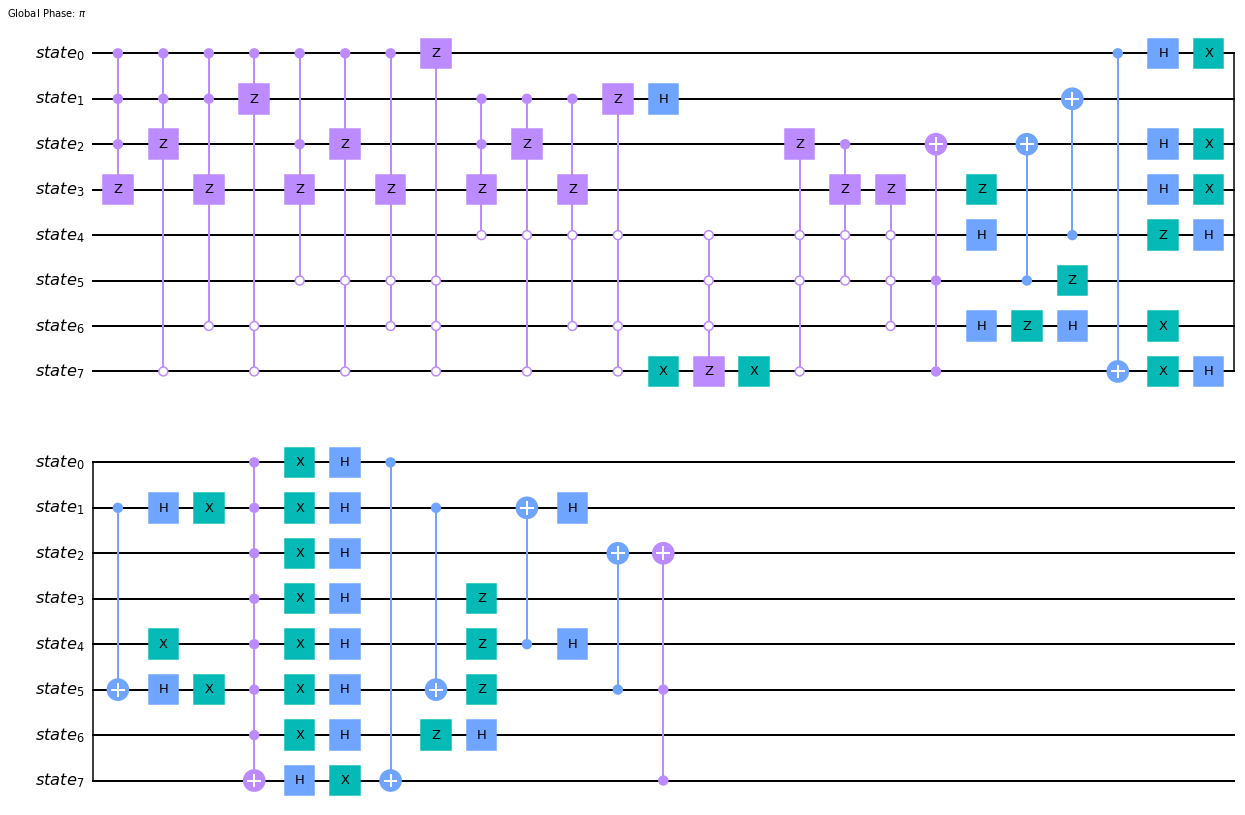

In [161]:
problem.grover_operator.draw(output='mpl')
